<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/NER/bert_ner_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/
* https://www.kaggle.com/vishakha10/ner-using-bert-model

Data Source:

* https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus


In [1]:
!pip install -U -q transformers
!pip install -U -q seqeval

     |████████████████████████████████| 1.9MB 11.4MB/s 
     |████████████████████████████████| 890kB 41.6MB/s 
     |████████████████████████████████| 3.2MB 39.9MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 


In [2]:
import pandas as pd
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score, classification_report

In [3]:
seed = 2021
max_len = 75
batch_size = 32
learning_rate = 3e-5
epochs = 100
max_grad_norm = 1.0
test_size = 0.1
earlystopping_patience = 3
model_name = "bert-base-cased"
checkpoint_path = "checkpoint.cpt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Get the raw dataset

!curl -s -LO https://github.com/MahmooudTaha/NLP-2019/raw/master/ner_dataset.csv.zip
!unzip -o ner_dataset.csv.zip
!rm -f ner_dataset.csv.zip

df = pd.read_csv("ner_dataset.csv", encoding="Windows-1252").fillna(method="ffill")
df.head()

Archive:  ner_dataset.csv.zip
  inflating: ner_dataset.csv         


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [5]:
class SentenceGetter(object):

  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                        s["POS"].values.tolist(),
                                                        s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]

  def get_next(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None


getter = SentenceGetter(df)
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[2] for s in sentence] for sentence in getter.sentences]

In [6]:
tag_values = list(set(df["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag_values)
print(tag2idx)

['B-eve', 'B-art', 'I-gpe', 'I-nat', 'B-nat', 'I-org', 'B-tim', 'B-org', 'I-eve', 'I-geo', 'O', 'B-per', 'I-per', 'B-gpe', 'I-art', 'I-tim', 'B-geo', 'PAD']
{'B-eve': 0, 'B-art': 1, 'I-gpe': 2, 'I-nat': 3, 'B-nat': 4, 'I-org': 5, 'B-tim': 6, 'B-org': 7, 'I-eve': 8, 'I-geo': 9, 'O': 10, 'B-per': 11, 'I-per': 12, 'B-gpe': 13, 'I-art': 14, 'I-tim': 15, 'B-geo': 16, 'PAD': 17}


In [7]:

tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)


def tokenize_and_preserve_labels(sentence, text_labels):
  tokenized_sentence = []
  labels = []
  for word, label in zip(sentence, text_labels):
    # Tokenize the word and count # of subwords the word is broken into
    tokenized_word = tokenizer.tokenize(word)
    n_subwords = len(tokenized_word)
    # Add the tokenized word to the final tokenized word list
    tokenized_sentence.extend(tokenized_word)
    # Add the same label to the new list of labels `n_subwords` times
    labels.extend([label] * n_subwords)
  return tokenized_sentence, labels


tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [8]:
input_ids = pad_sequences(sequences=[tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences(sequences=[[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=max_len, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [9]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, random_state=seed, test_size=test_size)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=seed, test_size=test_size)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
train_sampler = RandomSampler(train_data)
valid_sampler = SequentialSampler(valid_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [10]:
model = BertForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)

model.cuda()

FULL_FINETUNING = True
if FULL_FINETUNING:
  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "gamma", "beta"]
  optimizer_grouped_parameters = [
    {"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     "weight_decay_rate": 0.01},
    {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     "weight_decay_rate": 0.0}
  ]
else:
  param_optimizer = list(model.classifier.named_parameters())
  optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=learning_rate,
    eps=1e-8
)

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [11]:
def plot_perf(training_loss_values, validation_loss_values):
  # Use plot styling from seaborn.
  sns.set(style="darkgrid")
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12, 6)

  # Create a plot of loss over time
  loss = training_loss_values
  val_loss = validation_loss_values

  epochs = range(1, len(loss) + 1)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


In [12]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/NER/Model/checkpoint.pt', trace_func=print):
    """
    Args:
        patience (int): How long to wait after last time validation loss improved.
                        Default: 7
        verbose (bool): If True, prints a message for each validation loss improvement. 
                        Default: False
        delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                        Default: 0
        path (str): Path for the checkpoint to be saved to.
                        Default: 'checkpoint.pt'
        trace_func (function): trace print function.
                        Default: print            
    """
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf
    self.delta = delta
    self.path = path
    self.trace_func = trace_func

  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    if self.verbose:
      self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss


In [13]:

def train_model(model, train_dataloader):
  # ========================================
  #               Training
  # ========================================
  # Perform one full pass over the training set.

  # Put the model into training mode.
  model.train()
  # Reset the total loss for this epoch.
  total_loss = 0

  # Training loop
  for step, batch in enumerate(train_dataloader):
    # add batch to gpu
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    # Always clear any previously calculated gradients before performing a backward pass.
    model.zero_grad()
    # forward pass
    # This will return the loss (rather than the model output)
    # because we have provided the `labels`.
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)
    # get the loss
    loss = outputs[0]
    # Perform a backward pass to calculate the gradients.
    loss.backward()
    # track train loss
    total_loss += loss.item()
    # Clip the norm of the gradient
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
    # update parameters
    optimizer.step()
    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over the training data.
  avg_train_loss = total_loss / len(train_dataloader)
  print("\nAverage train loss: {}".format(avg_train_loss))
  return model, avg_train_loss


def validate_model(model, valid_dataloader):
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  # Put the model into evaluation mode
  model.eval()
  # Reset the validation loss for this epoch.
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  predictions , true_labels = [], []
  for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients,
    # saving memory and speeding up validation
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have not provided labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
    # Move logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

  eval_loss = eval_loss / len(valid_dataloader)
  print("Validation loss: {}".format(eval_loss))
  
  pred_tags = []
  for p, l in zip(predictions, true_labels):
    per_doc_pred_tags = []
    for p_i, l_i in zip(p, l):
      if tag_values[l_i] != "PAD":
        per_doc_pred_tags.append(tag_values[p_i])
    pred_tags.append(per_doc_pred_tags)

  valid_tags = []
  for l in true_labels:
    per_doc_valid_tags = []
    for l_i in l:
      if tag_values[l_i] != "PAD":
        per_doc_valid_tags.append(tag_values[l_i])
    valid_tags.append(per_doc_valid_tags)

  print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
  print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
  print("")
  print(classification_report(valid_tags, pred_tags))
  print("")
  return model, eval_loss


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]


Average train loss: 0.1908250608770736
Validation loss: 0.1321287426352501
Validation Accuracy: 0.9579151403649983
Validation F1-Score: 0.8039498169157813

              precision    recall  f1-score   support

         art       0.75      0.03      0.06        95
         eve       0.39      0.24      0.30        37
         geo       0.82      0.90      0.86      5885
         gpe       0.94      0.91      0.92      1870
         nat       0.88      0.23      0.37        30
         org       0.66      0.71      0.68      3561
         per       0.78      0.74      0.76      2799
         tim       0.86      0.83      0.85      2169

   micro avg       0.79      0.81      0.80     16446
   macro avg       0.76      0.57      0.60     16446
weighted avg       0.80      0.81      0.80     16446


Validation loss decreased (inf --> 0.132129).  Saving model ...


Epoch:   1%|          | 1/100 [19:28<32:07:52, 1168.40s/it]


Average train loss: 0.11147119986201279
Validation loss: 0.1279536418368419
Validation Accuracy: 0.9607158697044861
Validation F1-Score: 0.815221281164261

              precision    recall  f1-score   support

         art       0.33      0.07      0.12        95
         eve       0.30      0.32      0.31        37
         geo       0.84      0.90      0.86      5885
         gpe       0.94      0.91      0.93      1870
         nat       0.42      0.47      0.44        30
         org       0.68      0.71      0.69      3561
         per       0.76      0.81      0.79      2799
         tim       0.85      0.86      0.85      2169

   micro avg       0.80      0.83      0.82     16446
   macro avg       0.64      0.63      0.63     16446
weighted avg       0.80      0.83      0.81     16446


Validation loss decreased (0.132129 --> 0.127954).  Saving model ...


Epoch:   2%|▏         | 2/100 [38:54<31:47:27, 1167.83s/it]


Average train loss: 0.08231213276693562
Validation loss: 0.12759499743580818
Validation Accuracy: 0.9625967114016788
Validation F1-Score: 0.8263357045557742

              precision    recall  f1-score   support

         art       0.34      0.35      0.35        95
         eve       0.26      0.38      0.31        37
         geo       0.83      0.90      0.87      5885
         gpe       0.96      0.91      0.94      1870
         nat       0.50      0.43      0.46        30
         org       0.76      0.69      0.72      3561
         per       0.80      0.81      0.80      2799
         tim       0.85      0.86      0.85      2169

   micro avg       0.82      0.83      0.83     16446
   macro avg       0.66      0.67      0.66     16446
weighted avg       0.82      0.83      0.83     16446


Validation loss decreased (0.127954 --> 0.127595).  Saving model ...


Epoch:   3%|▎         | 3/100 [58:20<31:27:06, 1167.28s/it]


Average train loss: 0.06090999081567913
Validation loss: 0.13707026855399213
Validation Accuracy: 0.9631141482004698
Validation F1-Score: 0.830254572190056



Epoch:   4%|▍         | 4/100 [1:17:45<31:06:29, 1166.56s/it]

              precision    recall  f1-score   support

         art       0.43      0.24      0.31        95
         eve       0.29      0.38      0.33        37
         geo       0.85      0.89      0.87      5885
         gpe       0.96      0.91      0.94      1870
         nat       0.61      0.47      0.53        30
         org       0.79      0.67      0.72      3561
         per       0.78      0.83      0.80      2799
         tim       0.87      0.85      0.86      2169

   micro avg       0.84      0.82      0.83     16446
   macro avg       0.70      0.65      0.67     16446
weighted avg       0.84      0.82      0.83     16446


EarlyStopping counter: 1 out of 3

Average train loss: 0.04567345713553129
Validation loss: 0.1620881758381923
Validation Accuracy: 0.9630812950703879
Validation F1-Score: 0.8319090052005718



Epoch:   5%|▌         | 5/100 [1:37:09<30:45:55, 1165.85s/it]

              precision    recall  f1-score   support

         art       0.41      0.23      0.30        95
         eve       0.29      0.41      0.34        37
         geo       0.87      0.88      0.87      5885
         gpe       0.95      0.92      0.93      1870
         nat       0.39      0.47      0.42        30
         org       0.76      0.72      0.74      3561
         per       0.78      0.84      0.81      2799
         tim       0.85      0.86      0.85      2169

   micro avg       0.83      0.83      0.83     16446
   macro avg       0.66      0.66      0.66     16446
weighted avg       0.83      0.83      0.83     16446


EarlyStopping counter: 2 out of 3

Average train loss: 0.035357175083876514
Validation loss: 0.16768602651854356
Validation Accuracy: 0.9621285542980107
Validation F1-Score: 0.8289863842662631

              precision    recall  f1-score   support

         art       0.50      0.14      0.21        95
         eve       0.30      0.41      0.34  

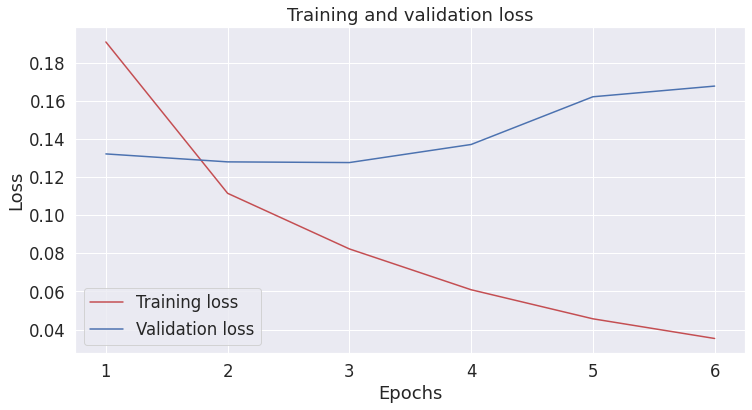

In [14]:

training_loss_values, validation_loss_values = [], []
# Initialize the early_stopping object
early_stopping = EarlyStopping(patience=earlystopping_patience, path=checkpoint_path, verbose=True)

for _ in trange(epochs, desc="Epoch"):
  # Training
  model, train_loss = train_model(model, train_dataloader)
  training_loss_values.append(train_loss)

  # Validation
  model, val_loss = validate_model(model, valid_dataloader)
  validation_loss_values.append(val_loss)

  # Early_stopping needs the validation loss to check if it has decresed, and if it has, it will make a checkpoint of the current model
  early_stopping(val_loss, model)
  
  if early_stopping.early_stop:
    print("Early stopping")
    break

# load the last checkpoint with the best model
model.load_state_dict(torch.load(checkpoint_path))

# Save entire model
torch.save(model, checkpoint_path)

plot_perf(training_loss_values, validation_loss_values)